## This experiment was performed using LightFM which a very popular recommender module and it has support to take in different data modalities such as text, image, graphical, etc. Please check out their official documentation in the link mentioned below:  
Link to LightFM:
making.lyst.com/lightfm/docs/home.html  

It also incorporates Multiprocessing to process predictions for final users

Please refer to the previous notebooks for different alterations. Summary of the alterations:  
1. Train Light FM without making use of any customer or article based feature on whole dataset. --> (https://www.kaggle.com/rickykonwar/h-m-lightfm-nofeatures)  
2. Train Light FM by making use of 1 article based feature on whole dataset --> Current Version  
3. Train Light FM by making use of 2 article based feature on whole dataset --> To Do
4. Train Light FM by making use of multiple article based features and also 1 customer based feature on whole dataset --> To Do

Hope you like this notebook, please feel free to vote for this notebook

## Importing Required Libraries

In [ ]:
# Importing Libraries
import sys, os
import re
import tqdm
import time
import pickle
import random
import itertools

import pandas as pd
import numpy as np
import scipy.sparse as sparse
%matplotlib inline
import matplotlib.pyplot as plt

# lightfm 
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.cross_validation import random_train_test_split

# multiprocessing for inferencing
from multiprocessing import Pool

In [ ]:
os.environ["openblas_set_num_threads"] = "1"
data_path = r'../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv'
customer_data_path = r'../input/h-and-m-personalized-fashion-recommendations/customers.csv'
article_data_path = r'../input/h-and-m-personalized-fashion-recommendations/articles.csv'
submission_data_path = r'../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv'

In [ ]:
# Data Extraction
def create_data(datapath, data_type=None):
    if data_type is None:
        df = pd.read_csv(datapath)
    elif data_type == 'transaction':
        df = pd.read_csv(datapath, dtype={'article_id': str}, parse_dates=['t_dat'])
    elif data_type == 'article':
        df = pd.read_csv(datapath, dtype={'article_id': str})
    return df

In [ ]:
%%time

# Load all sales data (for 3 years starting from 2018 to 2020)
# ALso, article_id is treated as a string column otherwise it 
# would drop the leading zeros while reading the specific column values
transactions_data=create_data(data_path, data_type='transaction')
print(transactions_data.shape)

# # Unique Attributes
print(str(len(transactions_data['t_dat'].drop_duplicates())) + "-total No of unique transactions dates in data sheet")
print(str(len(transactions_data['customer_id'].drop_duplicates())) + "-total No of unique customers ids in data sheet")
print(str(len(transactions_data['article_id'].drop_duplicates())) + "-total No of unique article ids courses names in data sheet")
print(str(len(transactions_data['sales_channel_id'].drop_duplicates())) + "-total No of unique sales channels in data sheet")

In [ ]:
transactions_data.head()

In [ ]:
transactions_data.info()

In [ ]:
%%time

# Load all Customers
customer_data=create_data(customer_data_path)
print(customer_data.shape)

print(str(len(customer_data['customer_id'].drop_duplicates())) + "-total No of unique customers ids in customer data sheet")

In [ ]:
customer_data.head()

In [ ]:
customer_data.info()

In [ ]:
%%time

# Load all Customers
article_data=create_data(article_data_path, data_type='article')
print(article_data.shape)

print(str(len(article_data['article_id'].drop_duplicates())) + "-total No of unique article ids in article data sheet")
print(str(len(article_data['product_group_name'].drop_duplicates())) + "-total No of unique product group names in article data sheet")

In [ ]:
article_data.head()

In [ ]:
article_data.info()

In [ ]:
# Unique Product Group Names
article_data['product_group_name'].unique()

## Capturing Seasonal Effect by Limiting the transaction date  

Based on notebook with link: https://www.kaggle.com/tomooinubushi/folk-of-time-is-our-best-friend/notebook

In [ ]:
transactions_data = transactions_data[transactions_data['t_dat'] > '2020-08-21']
transactions_data.shape

## Aggregating Customers and Articles irrespective of transaction dates

In [ ]:
transactions_data = transactions_data.groupby(['customer_id','article_id']).agg({'price':'sum','t_dat':'count'}).reset_index()
transactions_data = transactions_data[['customer_id','article_id','price']]
transactions_data.shape

In [ ]:
transactions_data.head()

## Merging transaction data with articles group name data

In [ ]:
# Combine article's product group name with transaction's data
merged_transactions_data = pd.merge(left=transactions_data, right=article_data[['article_id','product_group_name']], how='left', on='article_id')
merged_transactions_data.shape

In [ ]:
merged_transactions_data.head()

In [ ]:
merged_transactions_data.info()

## Generating user and article index mapping dictionaries

In [ ]:
def get_customers_list():
    # Creating a list of users
    # return np.sort(merged_transactions_data['customer_id'].unique()) TEMP_COMMENT
    return np.sort(customer_data['customer_id'].unique())

def get_articles_list():
    # Creating a list of courses 
    # item_list = merged_transactions_data['article_id'].unique() TEMP_COMMENT
    item_list = article_data['article_id'].unique()
    return item_list

def get_feature_list():
    # Creating a list of features
    # feature_list = merged_transactions_data['product_group_name'].unique() TEMP_COMMENT
    feature_list = article_data['product_group_name'].unique()
    return feature_list

def id_mappings(customers_list, articles_list, feature_list):
    """
    
    Create id mappings to convert user_id, item_id, and feature_id
    
    """
    customer_to_index_mapping = {}
    index_to_customer_mapping = {}
    for customer_index, customer_id in enumerate(customers_list):
        customer_to_index_mapping[customer_id] = customer_index
        index_to_customer_mapping[customer_index] = customer_id
        
    article_to_index_mapping = {}
    index_to_article_mapping = {}
    for article_index, article_id in enumerate(articles_list):
        article_to_index_mapping[article_id] = article_index
        index_to_article_mapping[article_index] = article_id
    
    feature_to_index_mapping = {}
    index_to_feature_mapping = {}
    for feature_index, feature_id in enumerate(feature_list):
        feature_to_index_mapping[feature_id] = feature_index
        index_to_feature_mapping[feature_index] = feature_id
        
    return customer_to_index_mapping, index_to_customer_mapping, \
           article_to_index_mapping, index_to_article_mapping, \
           feature_to_index_mapping, index_to_feature_mapping

In [ ]:
# Create customer, article and feature lists
customers = get_customers_list()
articles = get_articles_list()
features = get_feature_list()

In [ ]:
customers

In [ ]:
articles

In [ ]:
features

In [ ]:
# Generate mapping, LightFM library can't read other than (integer) index
customer_to_index_mapping, index_to_customer_mapping, \
article_to_index_mapping, index_to_article_mapping, \
feature_to_index_mapping, index_to_feature_mapping = id_mappings(customers, articles, features)

## Generate Customer Article Interaction Matrix

In [ ]:
def get_customer_article_interaction(customer_article_amt_df):
    #start indexing
    customer_article_amt_df["customer_id"] = customer_article_amt_df["customer_id"]
    customer_article_amt_df["article_id"] = customer_article_amt_df["article_id"]
    customer_article_amt_df["price"] = customer_article_amt_df["price"]

    # Preprocessing dataframe created
    customer_article_amt_df = customer_article_amt_df.rename(columns = {"price":"total_amount_spent"})

    # Replace Amount Column with category codes 
    customer_article_amt_df['total_amount_spent'] = customer_article_amt_df['total_amount_spent'].astype('category')
    customer_article_amt_df['total_amount_spent'] = customer_article_amt_df['total_amount_spent'].cat.codes

    return customer_article_amt_df

def get_interaction_matrix(df, df_column_as_row, df_column_as_col, 
                        df_column_as_value, row_indexing_map, col_indexing_map):
    
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return sparse.coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))

def get_article_feature_interaction(article_product_group_df, product_group_brand_weight = 1):
    # drop duplicates
    article_product_group_df = article_product_group_df.drop_duplicates()

    # start indexing
    article_product_group_df["article_id"] = article_product_group_df["article_id"]
    article_product_group_df["product_group_name"] = article_product_group_df["product_group_name"]

    # allocate "product_group_name" into one column as "feature"
    article_product_group_df = article_product_group_df[["article_id", "product_group_name"]].rename(columns = {"product_group_name" : "feature_01"})
    article_product_group_df["feature_count"] = product_group_brand_weight # adding weight to feature
        
    # grouping for summing over feature_count
    article_product_group_df = article_product_group_df.groupby(["article_id", "feature_01"], as_index = False)["feature_count"].sum()
    
    return article_product_group_df


In [ ]:
# Create customer and article interaction dataframe
customer_to_article = get_customer_article_interaction(customer_article_amt_df = merged_transactions_data[['customer_id','article_id','price']])

# Create article and feature interaction dataframe
article_to_feature = get_article_feature_interaction(article_product_group_df = merged_transactions_data[['article_id','product_group_name']], 
                                                    product_group_brand_weight = 1)

print(customer_to_article.shape)   
print(article_to_feature.shape)

In [ ]:
customer_to_article.head()

In [ ]:
article_to_feature.head()

In [ ]:
# Generate customer_article_interaction_matrix for train data
customer_to_article_interaction = get_interaction_matrix(customer_to_article, "customer_id", "article_id", "total_amount_spent", \
                                                    customer_to_index_mapping, article_to_index_mapping)

# Generate article_to_feature interaction
article_to_feature_interaction = get_interaction_matrix(article_to_feature, "article_id", "feature_01",  "feature_count", \
                                                       article_to_index_mapping, feature_to_index_mapping)

In [ ]:
customer_to_article_interaction

In [ ]:
article_to_feature_interaction

## Light FM Model Training

In [ ]:
#### FULL MODEL TRAINING ####
# Retraining the final model with full dataset
"""
Training model without any article or customer features
"""
final_model_without_feature = LightFM(loss = "warp")

# Fitting to combined dataset with pure collaborative filtering result
start = time.time() 
final_model_without_feature.fit(customer_to_article_interaction,
                                user_features=None, 
                                item_features=None, 
                                sample_weight=None, 
                                epochs=1, 
                                num_threads=4, 
                                verbose=False)
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

"""
Training model with article feature (article's product_group_name)
"""
final_model_with_1_feature = LightFM(loss = "warp")

# Fitting to combined dataset with pure collaborative filtering result
start = time.time() 
final_model_with_1_feature.fit(customer_to_article_interaction,
                            user_features=None, 
                            item_features=article_to_feature_interaction, 
                            sample_weight=None, 
                            epochs=1, 
                            num_threads=4, 
                            verbose=False)
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

## Recommendation sampling and Comparison with Known Positives

In [ ]:
class recommendation_sampling():
    def __init__(self, model, items = None, user_to_product_interaction_matrix = None, 
                item_features = None, user2index_map = None):
        
        self.user_to_product_interaction_matrix = user_to_product_interaction_matrix
        self.item_features = item_features if item_features is not None else None
        self.model = model
        self.items = items
        self.user2index_map = user2index_map
    
    def recommendation_for_user(self, user, k=3, prediction_type = 'normal'):
        # Getting the userindex
        userindex = self.user2index_map.get(user, None)
        if userindex == None:
            print("User %s not provided during Training the model" %(user))
            return None
        
        # Products already bought
        known_positives = self.items[self.user_to_product_interaction_matrix.tocsr()[userindex].indices]
        
        # Scores from model prediction
        scores = self.model.predict(user_ids = userindex, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1])) if prediction_type == 'normal' else \
            self.model.predict(user_ids = userindex, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]), item_features = self.item_features)
    
        # Top items
        top_items = self.items[np.argsort(-scores)]
        
        # Printing out the result
        print("User %s" % user)
        print("     Known positives:")
        for x in known_positives[:k]:
            print("                  %s" % x)
            
        print("     Recommended:")
        for x in top_items[:k]:
            print("                  %s" % x)

    def get_recommendation(self, user, k=3, prediction_type = 'normal'):
        # Getting the userindex
        userindex = self.user2index_map.get(user, None)
        if userindex == None:
            return None
        
        # Products already bought
        known_positives = self.items[self.user_to_product_interaction_matrix.tocsr()[userindex].indices]
        
        # Scores from model prediction
        scores = self.model.predict(user_ids = userindex, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1])) if prediction_type == 'normal' else \
            self.model.predict(user_ids = userindex, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]), item_features = self.item_features)
        
        # Top items
        top_items = self.items[np.argsort(-scores)]

        # Returning results
        recommended_list, recommender_count = [],1
        for item in top_items[:k]:
            recommended_list.append({'Priority': recommender_count,'Article': item})
            recommender_count+=1
        return known_positives, recommended_list
    
    def get_batched_recommendation(self, user, k=3, prediction_type='normal'):
        # Getting user_indexes 
        user_index = self.user2index_map.get(user, None)
        if user_index is None:
            return None
        
        # Scores from model
        scores = self.model.predict(user_ids = user_index, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1])) if prediction_type == 'normal' else \
            self.model.predict(user_ids = user_index, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]), item_features = self.item_features)
    
        # Top items
        top_items = self.items[np.argsort(-scores)]
        
        return top_items[:k]

In [ ]:
# Giving recommendations
recom_without_feature = recommendation_sampling(model = final_model_without_feature,
                                               items = articles,
                                               user_to_product_interaction_matrix = customer_to_article_interaction,
                                               user2index_map = customer_to_index_mapping)

recom_with_1_feature = recommendation_sampling(model = final_model_with_1_feature,
                                               items = articles,
                                               user_to_product_interaction_matrix = customer_to_article_interaction,
                                               item_features = article_to_feature_interaction,
                                               user2index_map = customer_to_index_mapping)

In [ ]:
recom_without_feature.recommendation_for_user('00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657')
recom_without_feature.recommendation_for_user('0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa')
recom_without_feature.recommendation_for_user('000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318')
recom_without_feature.recommendation_for_user('00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e')
recom_without_feature.recommendation_for_user('00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a')

In [ ]:
recom_with_1_feature.recommendation_for_user(user = '00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657', prediction_type = 'feature')
recom_with_1_feature.recommendation_for_user(user = '0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa', prediction_type = 'feature')
recom_with_1_feature.recommendation_for_user(user = '000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318', prediction_type = 'feature')
recom_with_1_feature.recommendation_for_user(user = '00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e', prediction_type = 'feature')
recom_with_1_feature.recommendation_for_user(user = '00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a', prediction_type = 'feature')

## MAP@12 Calculation for entire dataset

In [ ]:
sparse_customer_article_train, sparse_customer_article_test = random_train_test_split(customer_to_article_interaction, test_percentage=0.2, random_state=42)

In [ ]:
sparse_customer_article_train

In [ ]:
sparse_customer_article_test

### Cross Validation methodolody

In [ ]:
# Initialising model with warp loss function
model_with_1_feature = LightFM(loss = "warp")

# Fitting into user to product interaction matrix only / pure collaborative filtering factor
start = time.time()
model_with_1_feature.fit(sparse_customer_article_train,
                      user_features=None, 
                      item_features=article_to_feature_interaction, 
                      sample_weight=None, 
                      epochs=1, 
                      num_threads=4,
                      verbose=False)
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

### Writing Precision Calculation

In [ ]:
# Precision metric score (ranging from 0 to 1)
'''
k = 12
precision_with_1_article_feature = []
for precision_k in tqdm.tqdm(range(1,k+1), desc='Calculating Precisions at different k levels with 1 article feature'):
    start = time.time()
    precision_value = precision_at_k(model = model_with_1_feature, 
                                    test_interactions = sparse_customer_article_test,
                                    item_features = article_to_feature_interaction,
                                    num_threads = 4, 
                                    k=precision_k,
                                    check_intersections = False)
    print('Average Precision@k value for top %s numbered precision = %s' %(str(precision_k), str(precision_value.mean())))
    precision_with_1_article_feature.append(precision_value)
    end = time.time()
    print("Time taken for top %s number precision = %s seconds" %(str(precision_k), str(round(end-start,2))))
'''

### Screenshot of precision calculation
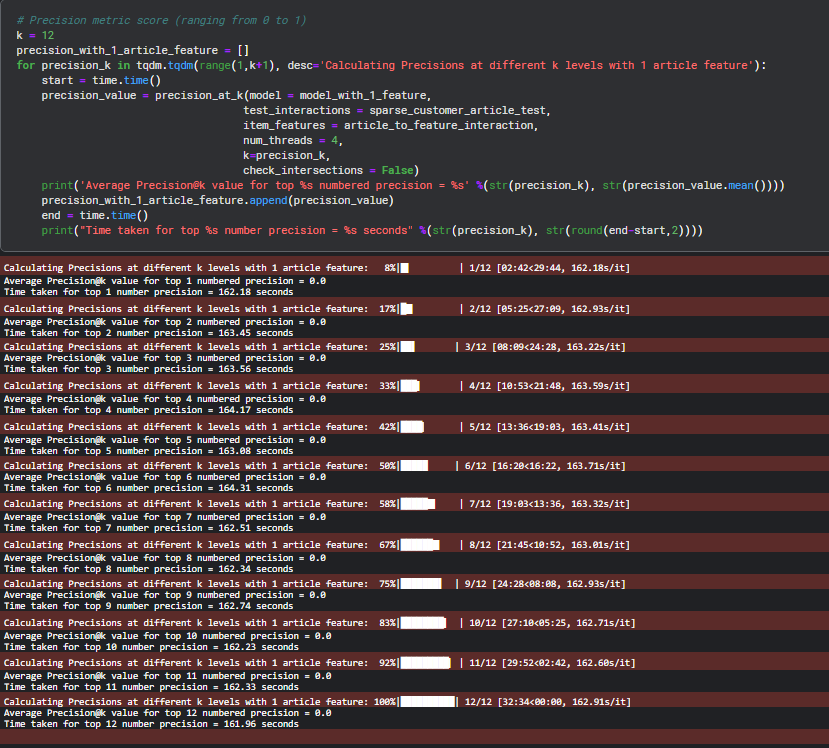

In [ ]:
'''
from numpy import save
save('./precision_with_1_article_feature_reduced.npy', precision_with_1_article_feature)
'''

In [ ]:
precision_with_1_article_feature = np.load('../input/hm-trained-models/lightfm_1articlefeature/precision_with_1_article_feature_reduced.npy')

### Calculating Average Precision@12

In [ ]:
map_12 = np.sum(precision_with_1_article_feature, axis=0) / 12

### Calculating Mean Average Precision

In [ ]:
print("average precision @ 12 by adding 1 article-feature interaction = {0:.{1}f}".format(map_12.mean(), 3)) 

## Saving Final Model with any feature

In [ ]:
with open('model_with_1_article_feature_reduced.pickle', 'wb') as fle:
    pickle.dump(final_model_with_1_feature, fle, protocol=pickle.HIGHEST_PROTOCOL)

## Getting Predictions based on submission template

In [ ]:
submission_data = pd.read_csv(submission_data_path)
submission_data.shape

In [ ]:
submission_data.head()

In [ ]:
submission_data.loc[submission_data.customer_id.isin([submission_data.customer_id.unique()[0]])].prediction[0].split(' ')

In [ ]:
def create_chunk_indices(meta_df, chunk_idx, chunk_size):
    '''
    Function to generate chunks of data for multiprocessing
    '''
    start_idx = chunk_idx * chunk_size
    end_idx = start_idx + chunk_size
    meta_chunk = meta_df[start_idx:end_idx]
    print("start/end "+str(chunk_idx+1)+":" + str(start_idx) + "," + str(end_idx))
    print(len(meta_chunk))
    #chunk_idx in return value is used to sort the processed chunks back into original order,
    return (meta_chunk, chunk_idx)

In [ ]:
def predict_sub_chunks(chunk):
    final_submission=[]
    for row in tqdm.tqdm(chunk[0].values):
        try:
            preds = recom_with_1_feature.get_batched_recommendation(user = row[0], k = 12, prediction_type = 'feature')
            if preds is not None:
                final_submission.append(' '.join(map(str, preds)))
            else:
                final_submission.append(row[1])
        except Exception as ex:
            print(ex)
    return final_submission

In [ ]:
num_cores=4

def predict_submission(submission_data=None):
    #splitting here by measurement id's to get all signals for a measurement into single chunk
    customer_ids = submission_data["customer_id"].unique()
    df_split = np.array_split(customer_ids, num_cores)
    chunk_size = len(df_split[0])
    
    chunk1 = create_chunk_indices(submission_data, 0, chunk_size)
    chunk2 = create_chunk_indices(submission_data, 1, chunk_size)
    chunk3 = create_chunk_indices(submission_data, 2, chunk_size)
    chunk4 = create_chunk_indices(submission_data, 3, chunk_size)
    
    #list of items for multiprocessing, 4 since using 4 cores
    all_chunks = [chunk1, chunk2, chunk3, chunk4]
    
    pool = Pool(num_cores)
    result = pool.map(predict_sub_chunks, all_chunks)
    
    result_combined = list(itertools.chain(result[0], result[1], result[2], result[3]))
    return result_combined

### The inferencing is done for first 1024 users in the sample file however you can find the complete prediction file in the dataset:  
LightFM dataset link: https://www.kaggle.com/rickykonwar/hm-trained-models

In [ ]:
final_predictions = predict_submission(submission_data[:1024])

### Screenshot of Inferencing entire sample submission data

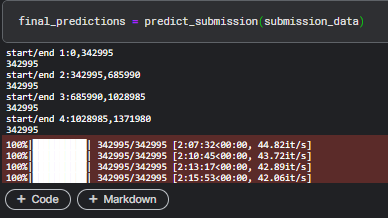

In [ ]:
len(final_predictions)

## Writing Intermediate Predictions

In [ ]:
final_submission_data = submission_data.copy()[:1024]
final_submission_data['prediction'] = final_predictions

In [ ]:
final_submission_data.head()

In [ ]:
final_submission_data.to_csv("intermediate_submission.csv", index=False)

In [ ]:
from IPython.display import FileLink
FileLink(r'intermediate_submission.csv')

## Writing Complete Predictions

In [ ]:
actual_submission_data = pd.read_csv(r'../input/hm-trained-models/lightfm_1articlefeature/submission_reduced.csv')
actual_submission_data.to_csv("submission.csv", index=False)

In [ ]:
from IPython.display import FileLink
FileLink(r'submission.csv')